# Creating hot gas density profiles and measuring gas mass

Though this work is generally concerned with detected absorption of background Quasar emission by warm gas in the intra-cluster/group medium, it also seemed appropriate to measure the quantity of hot, X-ray emitting, gas present in the intra-cluster medium. This involves creating a density profile, and there is a method (using surface brightness profiles) which can be used with low signal-to-noise extended sources. We then calculate the total gas mass by spherically integrating that profile within overdensity radii for all of our systems.

## Import Statements

In [47]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
import os
from shutil import rmtree
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 30
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/radial_prof_analyses')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model
from xga.products import BaseAggregateProfile1D
from xga.utils import r500 as r500_unit
    
%matplotlib inline

## Setting up directories

Need to make sure that some of the directories that we will be storing output files and figures in actually exist:

In [2]:
if not os.path.exists('../../outputs/results/'):
    os.makedirs('../../outputs/results/')
    
if not os.path.exists('../../outputs/figures/gm_prop_comparisons/'):
    os.makedirs('../../outputs/figures/gm_prop_comparisons/')

## Reading the XGA sample files

We read in the files generated by our various runs of the XGA-LTR in another notebook in this repository. They contain the radii we measured, as well as all the other information that we need to declare an XGA ClusterSample:

In [3]:
r500_samp = pd.read_csv('../../outputs/results/ltr_r500_pipeline_results.csv')
r500_metfree_samp = pd.read_csv('../../outputs/results/ltr_r500_metfree_pipeline_results.csv')
r500_froztemp_samp = pd.read_csv('../../outputs/results/ltr_r500_froztemp_pipeline_results.csv')

r2500_samp = pd.read_csv('../../outputs/results/ltr_r2500_pipeline_results.csv')
r2500_metfree_samp = pd.read_csv('../../outputs/results/ltr_r2500_metfree_pipeline_results.csv')
r2500_froztemp_samp = pd.read_csv('../../outputs/results/ltr_r2500_froztemp_pipeline_results.csv')

We show one of the dataframes to illustrate the contents:

In [4]:
r500_samp

,name,ra,dec,redshift,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
0,25124A,243.629055,26.730240,0.186,893.382668,44.137856,4.083410,0.334322,0.422878,7.141392e+43,1.087654e+42,1.492620e+42,2.118114e+44,1.309129e+43,1.154102e+43,4.158680,0.560650,0.831335,4.376124e+43,1.316098e+42,1.213119e+42,1.309041e+44,1.154301e+43,1.335210e+43
1,25124B,243.504000,26.691000,0.186,232.394173,46.383464,2.586690,0.737052,2.403693,1.707848e+42,2.602582e+41,4.887286e+41,4.166720e+42,9.891285e+41,1.124987e+42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25124C,243.541000,26.648000,0.186,494.381609,20.414587,1.410110,0.082260,0.093876,6.803658e+42,5.325387e+41,3.035177e+41,1.357180e+43,8.903220e+41,1.105397e+42,1.406590,0.085928,0.094737,6.597141e+42,5.658309e+41,4.671014e+41,1.314807e+43,1.316791e+42,1.058266e+42
3,44739,229.793620,28.331750,0.118,419.408006,22.236682,1.053210,0.077640,0.081511,2.141382e+42,2.108863e+41,1.848539e+41,3.794535e+42,5.163472e+41,4.734131e+41,1.024260,0.081872,0.090932,1.729590e+42,3.360183e+41,2.207034e+41,3.026989e+42,5.011803e+41,4.268552e+41
4,19670AB,150.226402,50.800565,0.134,572.934243,55.185550,1.325860,0.127974,0.175725,2.589064e+42,4.113469e+41,2.829265e+41,5.071690e+42,8.988664e+41,8.896770e+41,1.271900,0.120733,0.170133,2.137764e+42,3.334210e+41,3.810820e+41,4.119329e+42,9.036346e+41,6.926172e+41
5,19670A,150.256710,50.793942,0.134,469.710739,31.768708,1.217230,0.119191,0.135531,1.502793e+42,2.852948e+41,2.500183e+41,2.844038e+42,5.718452e+41,5.578615e+41,1.167150,0.141568,0.188398,1.145528e+42,3.704302e+41,3.244274e+41,2.126675e+42,6.800261e+41,7.860462e+41
6,19670B,150.214920,50.805014,0.134,577.830170,45.142869,2.028900,0.287583,0.502016,4.809527e+42,3.964663e+41,3.994757e+41,1.083288e+43,1.165593e+42,1.183599e+42,1.756620,0.264668,0.358291,3.826824e+42,3.990364e+41,4.445714e+41,8.239713e+42,9.896431e+41,1.185665e+42
7,19670C,150.065000,50.746000,0.134,448.295618,255.921764,1.334250,0.208387,0.346770,8.381808e+41,3.707784e+41,2.047819e+41,1.645934e+42,6.414924e+41,8.151613e+41,1.262090,0.214472,0.311864,6.159195e+41,3.599597e+41,2.881152e+41,1.182900e+42,5.326862e+41,7.425364e+41
8,19670D,150.168000,50.686000,0.134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12833A,129.496800,44.248700,0.145,495.615682,24.676327,1.340700,0.080378,0.101755,3.418327e+42,2.412858e+41,4.055623e+41,6.725962e+42,7.968244e+41,8.180290e+41,1.324570,0.117213,0.170060,2.147349e+42,3.545853e+41,3.531595e+41,4.205251e+42,7.012826e+41,7.028584e+41


We remove the two entries with NaN $R_{500}$ values <font color='red'>(for now)</font>:

In [5]:
r500_samp = r500_samp[~np.isnan(r500_samp['r500'])].reset_index(drop=True)
r500_samp

,name,ra,dec,redshift,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
0,25124A,243.629055,26.730240,0.186,893.382668,44.137856,4.083410,0.334322,0.422878,7.141392e+43,1.087654e+42,1.492620e+42,2.118114e+44,1.309129e+43,1.154102e+43,4.158680,0.560650,0.831335,4.376124e+43,1.316098e+42,1.213119e+42,1.309041e+44,1.154301e+43,1.335210e+43
1,25124B,243.504000,26.691000,0.186,232.394173,46.383464,2.586690,0.737052,2.403693,1.707848e+42,2.602582e+41,4.887286e+41,4.166720e+42,9.891285e+41,1.124987e+42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25124C,243.541000,26.648000,0.186,494.381609,20.414587,1.410110,0.082260,0.093876,6.803658e+42,5.325387e+41,3.035177e+41,1.357180e+43,8.903220e+41,1.105397e+42,1.406590,0.085928,0.094737,6.597141e+42,5.658309e+41,4.671014e+41,1.314807e+43,1.316791e+42,1.058266e+42
3,44739,229.793620,28.331750,0.118,419.408006,22.236682,1.053210,0.077640,0.081511,2.141382e+42,2.108863e+41,1.848539e+41,3.794535e+42,5.163472e+41,4.734131e+41,1.024260,0.081872,0.090932,1.729590e+42,3.360183e+41,2.207034e+41,3.026989e+42,5.011803e+41,4.268552e+41
4,19670AB,150.226402,50.800565,0.134,572.934243,55.185550,1.325860,0.127974,0.175725,2.589064e+42,4.113469e+41,2.829265e+41,5.071690e+42,8.988664e+41,8.896770e+41,1.271900,0.120733,0.170133,2.137764e+42,3.334210e+41,3.810820e+41,4.119329e+42,9.036346e+41,6.926172e+41
5,19670A,150.256710,50.793942,0.134,469.710739,31.768708,1.217230,0.119191,0.135531,1.502793e+42,2.852948e+41,2.500183e+41,2.844038e+42,5.718452e+41,5.578615e+41,1.167150,0.141568,0.188398,1.145528e+42,3.704302e+41,3.244274e+41,2.126675e+42,6.800261e+41,7.860462e+41
6,19670B,150.214920,50.805014,0.134,577.830170,45.142869,2.028900,0.287583,0.502016,4.809527e+42,3.964663e+41,3.994757e+41,1.083288e+43,1.165593e+42,1.183599e+42,1.756620,0.264668,0.358291,3.826824e+42,3.990364e+41,4.445714e+41,8.239713e+42,9.896431e+41,1.185665e+42
7,19670C,150.065000,50.746000,0.134,448.295618,255.921764,1.334250,0.208387,0.346770,8.381808e+41,3.707784e+41,2.047819e+41,1.645934e+42,6.414924e+41,8.151613e+41,1.262090,0.214472,0.311864,6.159195e+41,3.599597e+41,2.881152e+41,1.182900e+42,5.326862e+41,7.425364e+41
8,12833A,129.496800,44.248700,0.145,495.615682,24.676327,1.340700,0.080378,0.101755,3.418327e+42,2.412858e+41,4.055623e+41,6.725962e+42,7.968244e+41,8.180290e+41,1.324570,0.117213,0.170060,2.147349e+42,3.545853e+41,3.531595e+41,4.205251e+42,7.012826e+41,7.028584e+41
9,12833B,129.445000,44.379000,0.145,450.744382,33.734404,1.110170,0.116981,0.129359,2.412061e+42,3.340796e+41,2.668888e+41,4.376238e+42,7.661348e+41,5.068742e+41,0.924213,0.109034,0.125370,1.283403e+42,3.650833e+41,2.377132e+41,2.147495e+42,5.004516e+41,4.286821e+41


## Setting up an XGA ClusterSample

We set up an XGA ClusterSample object for our systems - this will allow us to easily interact with all the XMM data for these objects, and perform measurements of their hot-gas density profiles. We make sure to set `use_peak=False`, so that the user defined coordinate (UDC) is used as the central position, as some of these systems are low enough signal to noise that they may produce unreliable peak coordinates:

In [6]:
srcs = ClusterSample(r500_samp['ra'].values, r500_samp['dec'].values, r500_samp['redshift'].values, 
                     r500_samp['name'].values, r500=Quantity(r500_samp['r500'].values, 'kpc'), 
                     use_peak=False, load_fits=True)
srcs.info()
srcs.suppressed_warnings

Setting up Galaxy Clusters: 100%|██████████| 14/14 [00:16<00:00,  1.15s/it]


-----------------------------------------------------
Number of Sources - 14
Redshift Information - True
Sources with ≥1 detection - 12 [86%]
-----------------------------------------------------




/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:279: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


{'44739': ['There are 1 alternative matches for observation 0900700201, associated with source 44739'],
 '19670AB': ['A point source has been detected in 0861080101 and is very close to the user supplied coordinates of 19670AB. It will not be excluded from analysis due to the possibility of a mis-identified cool core'],
 '19670A': ['There are 1 alternative matches for observation 0861080101, associated with source 19670A'],
 '19670B': ['A point source has been detected in 0861080101 and is very close to the user supplied coordinates of 19670B. It will not be excluded from analysis due to the possibility of a mis-identified cool core'],
 'J215504.8-093520': ["J215504.8-093520 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data"],
 'J215437.2-091532.4': ['A PSF sized extended source has been detected in 0204310101 and is very close to the user supplied coordinates of J215437.2-091532.4. It will not be ex

## Generating hot gas density profiles

We generate surface brightness profiles, from ratemaps that have been corrected for the spatially varying PSF, and fit a simple $\beta$ model to them. This is inverse Abel transformed to recover a 3D emissivity profile, which in turn is used to calculate a 3D hot-baryon density profile with assumptions made about the emission model for the gas.

We have decided to generate the profiles to an outer radius of <font color="red">$1.1R_{500}$</font>, where the $R_{500}$ in question is that measured from the 'standard' XGA-LTR run:

In [39]:
rl_psf(srcs, bins=10)
d_profs = inv_abel_fitted_model(srcs, 'beta', outer_radius=srcs.r500*1, psf_bins=10, pix_step=2)

/mnt/ufs18/home-218/turne540/code/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:  14%|█▍        | 2/14 [00:32<03:11, 15.95s/it]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of 25124C's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  21%|██▏       | 3/14 [00:46<02:49, 15.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [538.32580537 581.00031045 840.3874374 ]


Fitting data, inverse Abel transforming, and measuring densities:  50%|█████     | 7/14 [01:50<01:50, 15.83s/it]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of 19670C's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  57%|█████▋    | 8/14 [02:03<01:30, 15.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 194.17542562  862.15057316 1227.29990592]


Fitting data, inverse Abel transforming, and measuring densities: 100%|██████████| 14/14 [03:45<00:00, 16.08s/it]


Viewing the surface brightness profiles:

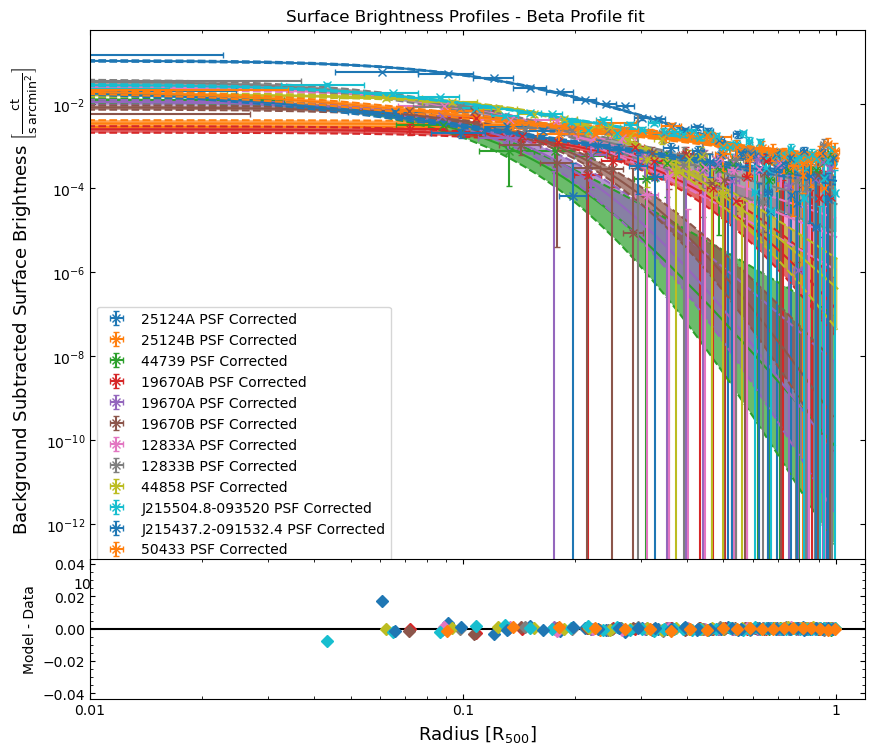

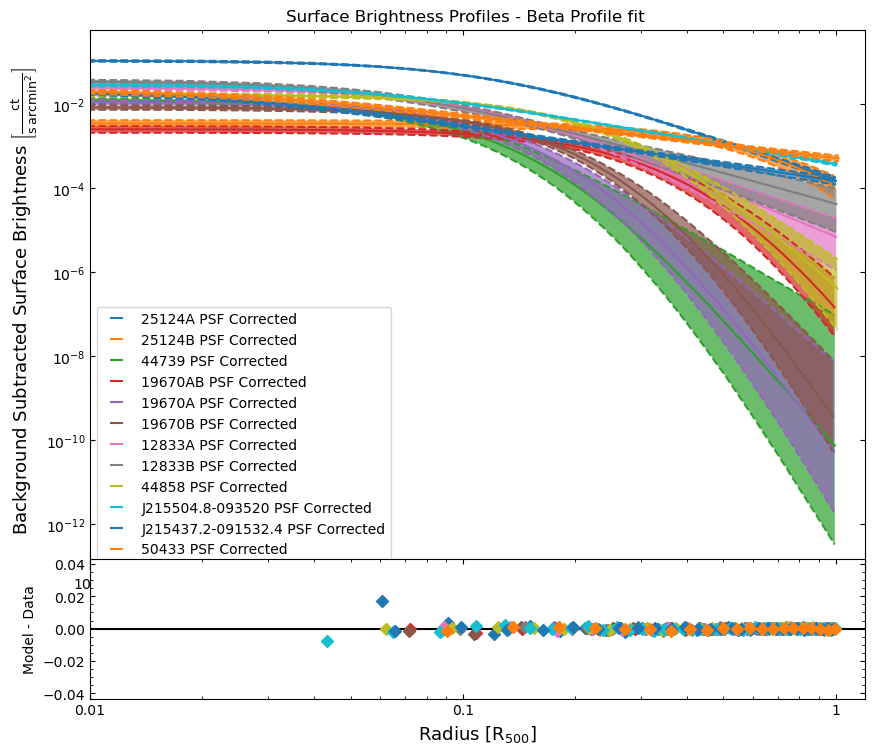

In [63]:
sb_profs = []
for dp in d_profs:
    if dp is not None:
        dp.x_norm = srcs[dp.src_name].r500 / Quantity(1, r500_unit)
        dp.generation_profile.x_norm = srcs[dp.src_name].r500 / Quantity(1, r500_unit)
        sb_profs.append(dp.generation_profile)

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
BaseAggregateProfile1D(sb_profs).view(model='beta', just_model=False, x_norm=True, axis_formatters=forms, 
                                      xlim=[0.01, 1.2], save_path='../../outputs/figures/sb_profs.pdf')
BaseAggregateProfile1D(sb_profs).view(model='beta', just_model=True, x_norm=True, axis_formatters=forms, 
                                      xlim=[0.01, 1.2], save_path='../../outputs/figures/sb_profs_justmod.pdf')

We also view the generated density profiles on one figure, and then save it to disk:

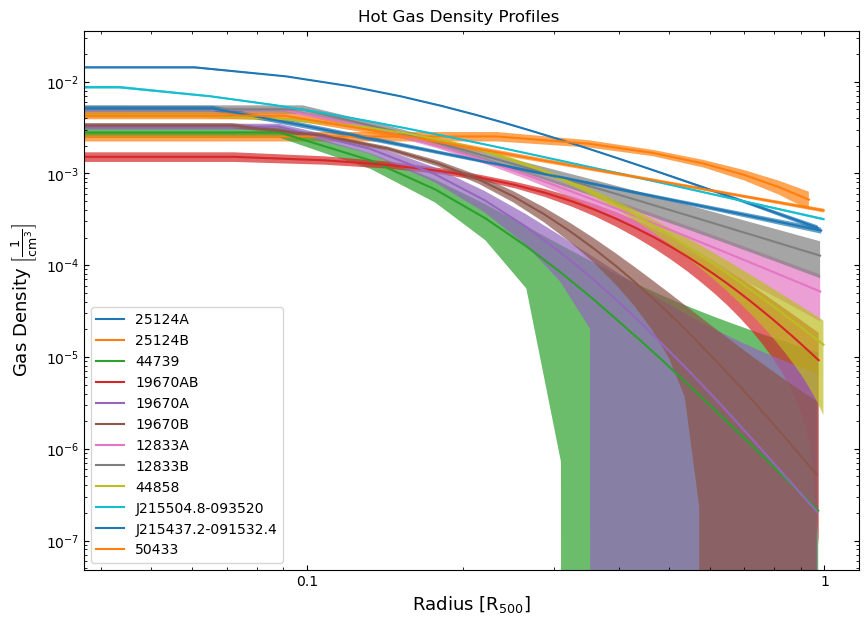

In [54]:
agg_dp = BaseAggregateProfile1D([dp for dp in d_profs if dp is not None])

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
agg_dp.view(joined_points=True, custom_title='Hot Gas Density Profiles', x_norm=True, axis_formatters=forms,
            save_path='../../outputs/figures/hot_gas_dens_profs.pdf')

## Showing brightness profile model parameters

We want to save the model parameters that describe each surface brightness profile to disk in a table (rather than just in the profile objects that XGA automatically saves to disk):

In [114]:
data = []
cols = ['name', 'beta', 'beta-', 'beta+', 'r_core', 'r_core-', 'r_core+','norm', 'norm-', 'norm+']
for src_ind, src in enumerate(srcs):
    if d_profs[src_ind] is not None:
        sb = d_profs[src_ind].generation_profile
        mod = sb.get_model_fit('beta', 'mcmc')
        par_vals = mod.model_pars
        par_errs = mod.model_par_errs
        cur_dat = [src.name, par_vals[0].value, *par_errs[0].value, par_vals[1].value, *par_errs[1].value, 
                   par_vals[2].value, *par_errs[2].value]
    else:
        cur_dat = [src.name] + [np.NaN]*9
    data.append(cur_dat)

print(mod.par_names)
print(mod.par_units)
    
sb_mod_df = pd.DataFrame(data, columns=cols).round(3)
sb_mod_df.to_csv("../../outputs/results/sb_beta_mod_pars.csv", index=False)
sb_mod_df

['beta', 'r_core', 'norm']
[Unit(dimensionless), Unit("kpc"), Unit("ct / (arcmin2 s)")]


,name,beta,beta-,beta+,r_core,r_core-,r_core+,norm,norm-,norm+
0,25124A,0.683,0.024,0.027,109.693,7.481,7.630,0.106,0.004,0.005
1,25124B,2.038,0.812,0.617,244.750,68.947,58.230,0.003,0.001,0.001
2,25124C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44739,1.857,0.877,0.766,64.339,24.486,18.548,0.012,0.002,0.002
4,19670AB,2.215,0.699,0.492,284.332,63.154,55.228,0.002,0.000,0.000
5,19670A,2.144,0.752,0.553,96.434,24.169,18.769,0.011,0.002,0.002
6,19670B,2.328,0.626,0.422,163.505,28.994,20.315,0.008,0.001,0.001
7,19670C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12833A,0.872,0.123,0.237,60.847,11.626,18.442,0.025,0.003,0.003
9,12833B,0.641,0.085,0.160,32.399,8.049,12.037,0.035,0.004,0.004


In [113]:
form_str = "${v}^{{+{p}}}_{{-{m}}}$"

tab_str = ""
for row_ind, row in sb_mod_df.iterrows():
    row_val = row.values.astype(str)
    beta_str = form_str.format(v=row_val[1], m=row_val[2], p=row_val[3])
    rc_str = form_str.format(v=row_val[4], m=row_val[5], p=row_val[6])
    n_str = form_str.format(v=row_val[7], m=row_val[8], p=row_val[9])    

    cur_line = row_val[0] + ' & ' + beta_str + ' & ' + rc_str + ' & ' + n_str + '\\\[1.5mm]\n%\n'
    tab_str += cur_line
print(tab_str)

25124A & $0.683^{+0.027}_{-0.024}$ & $109.693^{+7.63}_{-7.481}$ & $0.106^{+0.005}_{-0.004}$\\[1.5mm]
%
25124B & $2.038^{+0.617}_{-0.812}$ & $244.75^{+58.23}_{-68.947}$ & $0.003^{+0.001}_{-0.001}$\\[1.5mm]
%
25124C & $nan^{+nan}_{-nan}$ & $nan^{+nan}_{-nan}$ & $nan^{+nan}_{-nan}$\\[1.5mm]
%
44739 & $1.857^{+0.766}_{-0.877}$ & $64.339^{+18.548}_{-24.486}$ & $0.012^{+0.002}_{-0.002}$\\[1.5mm]
%
19670AB & $2.215^{+0.492}_{-0.699}$ & $284.332^{+55.228}_{-63.154}$ & $0.002^{+0.0}_{-0.0}$\\[1.5mm]
%
19670A & $2.144^{+0.553}_{-0.752}$ & $96.434^{+18.769}_{-24.169}$ & $0.011^{+0.002}_{-0.002}$\\[1.5mm]
%
19670B & $2.328^{+0.422}_{-0.626}$ & $163.505^{+20.315}_{-28.994}$ & $0.008^{+0.001}_{-0.001}$\\[1.5mm]
%
19670C & $nan^{+nan}_{-nan}$ & $nan^{+nan}_{-nan}$ & $nan^{+nan}_{-nan}$\\[1.5mm]
%
12833A & $0.872^{+0.237}_{-0.123}$ & $60.847^{+18.442}_{-11.626}$ & $0.025^{+0.003}_{-0.003}$\\[1.5mm]
%
12833B & $0.641^{+0.16}_{-0.085}$ & $32.399^{+12.037}_{-8.049}$ & $0.035^{+0.004}_{-0.004}$\\[1.5mm]
%

## Measuring hot gas mass

Now that we have generated 3D density profiles, it is trivial to calculate the gas mass enclosed within some radii. This is done for the $R_{500}$ and $R_{2500}$ results of the three different ways that we ran the XGA-LTR:

In [65]:
gm500 = []
gm2500 = []
metfree_gm500 = []
metfree_gm2500 = []
froztemp_gm500 = []
froztemp_gm2500 = []

for dp in d_profs:
    if dp is not None:
        rel_src = srcs[dp.src_name]
        dp.fit('king', progress_bar=False)
        r500_err = Quantity(r500_samp[r500_samp['name'] == rel_src.name].iloc[0]['r500+-'], 'kpc')
        gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
        
        rel_rad = Quantity(r2500_samp[r2500_samp['name'] == rel_src.name].iloc[0]['r2500'], 'kpc')
        rel_rad_err = Quantity(r2500_samp[r2500_samp['name'] == rel_src.name].iloc[0]['r2500+-'], 'kpc')
        gm2500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
        rel_rad = Quantity(r500_metfree_samp[r500_metfree_samp['name'] == rel_src.name].iloc[0]['r500'], 'kpc')
        rel_rad_err = Quantity(r500_metfree_samp[r500_metfree_samp['name'] == 
                                                 rel_src.name].iloc[0]['r500+-'], 'kpc')
        metfree_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
        rel_rad = Quantity(r2500_metfree_samp[r2500_metfree_samp['name'] == rel_src.name].iloc[0]['r2500'], 'kpc')
        rel_rad_err = Quantity(r2500_metfree_samp[r2500_metfree_samp['name'] == 
                                                  rel_src.name].iloc[0]['r2500+-'], 'kpc')
        metfree_gm2500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
        rel_rad = Quantity(r500_froztemp_samp[r500_froztemp_samp['name'] == rel_src.name].iloc[0]['r500'], 'kpc')
        rel_rad_err = Quantity(r500_froztemp_samp[r500_froztemp_samp['name'] == 
                                                  rel_src.name].iloc[0]['r500+-'], 'kpc')
        froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
        
        rel_rad = Quantity(r2500_froztemp_samp[r2500_froztemp_samp['name'] == rel_src.name].iloc[0]['r2500'], 
                           'kpc')
        rel_rad_err = Quantity(r2500_froztemp_samp[r2500_froztemp_samp['name'] == 
                                                   rel_src.name].iloc[0]['r2500+-'], 'kpc')
        froztemp_gm2500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
    else:
        null_res = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        gm500.append(null_res)
        gm2500.append(null_res)
        metfree_gm500.append(null_res)
        metfree_gm2500.append(null_res)
        froztemp_gm500.append(null_res)
        froztemp_gm2500.append(null_res)
    
gm500 = Quantity(gm500)
gm500[gm500 == 0] = np.NaN
gm2500 = Quantity(gm2500)
gm2500[gm2500 == 0] = np.NaN

metfree_gm500 = Quantity(metfree_gm500)
metfree_gm500[metfree_gm500 == 0] = np.NaN
metfree_gm2500 = Quantity(metfree_gm2500)
metfree_gm2500[metfree_gm2500 == 0] = np.NaN

froztemp_gm500 = Quantity(froztemp_gm500)
froztemp_gm500[froztemp_gm500 == 0] = np.NaN
froztemp_gm2500 = Quantity(froztemp_gm2500)
froztemp_gm2500[froztemp_gm2500 == 0] = np.NaN

/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:1163: UserWarning: king already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
/tmp/local/31786187/ipykernel_123257/3090085091.py:13: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/31786187/ipykernel_123257/3090085091.py:22: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  metfree_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
/tmp/local/31786187/ipykernel_123257/3090085091.py:32: UserWarning: The outer radius you supplied is greater than or equal to the outer ra

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [112.91895517 643.53450114 497.38958079]


/tmp/local/31786187/ipykernel_123257/3090085091.py:13: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/31786187/ipykernel_123257/3090085091.py:32: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])


## Saving gas masses

Now that we have measured the gas masses, we wish to save them to a csv:

In [90]:
gm_data = (np.hstack([gm500, gm2500, metfree_gm500, metfree_gm2500, froztemp_gm500, 
                     froztemp_gm2500]).value / 1e+13).round(4)
gm_data = np.hstack([srcs.names[..., None], gm_data])

gm_cols = ['name', 'gm500', 'gm500-', 'gm500+', 'gm2500', 'gm2500-', 'gm2500+', 
           'gm_metfree500', 'gm_metfree500-', 'gm_metfree500+', 'gm_metfree2500', 'gm_metfree2500-', 
           'gm_metfree2500+', 
           'gm_froztemp500', 'gm_froztemp500-', 'gm_froztemp500+', 'gm_froztemp2500', 'gm_froztemp2500-', 
           'gm_froztemp2500+']

gm_pd = pd.DataFrame(gm_data, columns=gm_cols)
gm_pd.to_csv("../../outputs/results/all_hot_gm_measurements.csv", index=False)
gm_pd

,name,gm500,gm500-,gm500+,gm2500,gm2500-,gm2500+,gm_metfree500,gm_metfree500-,gm_metfree500+,gm_metfree2500,gm_metfree2500-,gm_metfree2500+,gm_froztemp500,gm_froztemp500-,gm_froztemp500+,gm_froztemp2500,gm_froztemp2500-,gm_froztemp2500+
0,25124A,2.7983,0.1615,0.1582,0.8845,0.045,0.0465,2.7043,0.1707,0.1753,0.8823,0.0533,0.0533,2.7015,0.0584,0.059,1.0261,0.0222,0.0213
1,25124B,0.0727,0.0204,0.0174,0.0896,0.0089,0.0101,0.1094,0.0133,0.0191,nan,nan,nan,0.1203,0.0169,0.0316,0.0801,0.0061,0.0066
2,25124C,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,44739,0.0071,0.0012,0.0015,0.0069,0.001,0.0011,0.0071,0.0012,0.0015,nan,nan,nan,0.0071,0.0012,0.0016,0.0069,0.001,0.0012
4,19670AB,0.0978,0.0065,0.0066,0.0586,0.0045,0.0046,0.0954,0.0059,0.006,nan,nan,nan,0.096,0.0057,0.0054,0.0551,0.0034,0.0034
5,19670A,0.015,0.0018,0.0021,0.0143,0.0014,0.0015,0.015,0.0018,0.0021,nan,nan,nan,0.015,0.0018,0.0021,nan,nan,nan
6,19670B,0.045,0.0028,0.0029,0.0407,0.0019,0.002,0.0449,0.0027,0.0028,0.0389,0.002,0.0021,0.0449,0.0027,0.0028,0.0359,0.0019,0.0019
7,19670C,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,12833A,0.1251,0.0096,0.0101,0.0566,0.0031,0.003,0.1222,0.0096,0.0101,0.0555,0.0032,0.0033,0.1385,0.0109,0.0116,0.0692,0.0035,0.0037
9,12833B,0.1562,0.0181,0.0209,nan,nan,nan,0.1413,0.0159,0.018,nan,nan,nan,0.1786,0.0181,0.0197,0.0664,0.0048,0.005


## Comparing hot gas masses

As discussed in the XGA-LTR notebook elsewhere in this repository, we have run the pipeline which measures overdensity radii in three different modes, which results in slightly different values - as we measure the hot gas mass within a particular radius we compare the results from all the different versions of $R_{500}$ and $R_{2500}$:

In [91]:
stand_col = 'tab:cyan'
metfree_col = 'firebrick'
froztemp_col = 'goldenrod'

### $R_{500}$

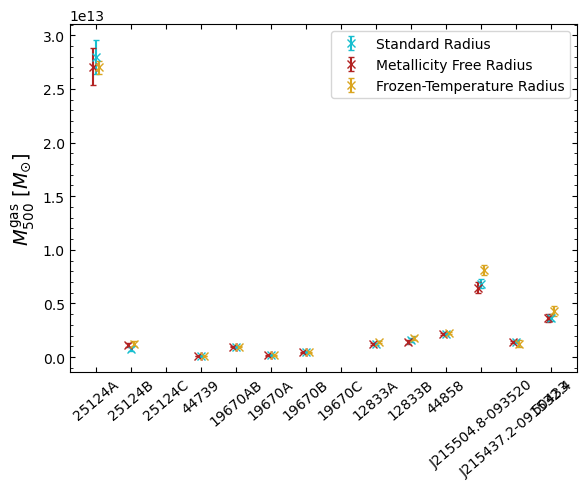

In [92]:
x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.errorbar(range(len(srcs)), gm500[:, 0].value, yerr=gm500[:, 1:].T.value, fmt='x', label="Standard Radius", 
             color=stand_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) - x_offset, metfree_gm500[:, 0].value, 
             yerr=metfree_gm500[:, 1:].T.value, fmt='x', 
             label="Metallicity Free Radius", color=metfree_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) + x_offset, froztemp_gm500[:, 0].value, 
             yerr=froztemp_gm500[:, 1:].T.value, fmt='x', 
             label="Frozen-Temperature Radius", color=froztemp_col, capsize=2)

plt.ylabel(r"$M^{\rm{gas}}_{500}$ [$M_{\odot}$]", fontsize=14)

plt.xticks(ticks=range(len(srcs)), labels=srcs.names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

plt.legend()
plt.tight_layout()

plt.savefig('../../outputs/figures/gm_prop_comparisons/gm500_comp.pdf')
plt.show()

### $R_{2500}$

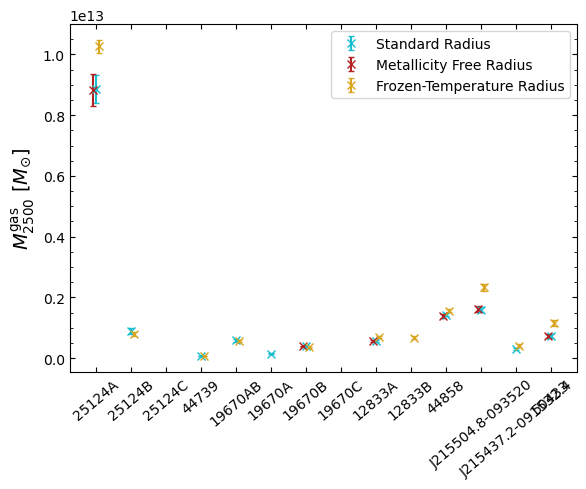

In [93]:
x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.errorbar(range(len(srcs)), gm2500[:, 0].value, yerr=gm2500[:, 1:].T.value, fmt='x', label="Standard Radius", 
             color=stand_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) - x_offset, metfree_gm2500[:, 0].value, 
             yerr=metfree_gm2500[:, 1:].T.value, fmt='x', 
             label="Metallicity Free Radius", color=metfree_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) + x_offset, froztemp_gm2500[:, 0].value, 
             yerr=froztemp_gm2500[:, 1:].T.value, fmt='x', 
             label="Frozen-Temperature Radius", color=froztemp_col, capsize=2)

plt.ylabel(r"$M^{\rm{gas}}_{2500}$ [$M_{\odot}$]", fontsize=14)

plt.xticks(ticks=range(len(srcs)), labels=srcs.names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

plt.legend()
plt.tight_layout()

plt.savefig('../../outputs/figures/gm_prop_comparisons/gm2500_comp.pdf')
plt.show()